In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import xarray as xr
from sklearn import linear_model
import pickle

In [2]:
%matplotlib inline

Workflow for ASMO optimization is available from https://github.com/NCAR/ctsm_optz

The workflow consists of the following algorithm:
1. Initial sample: Latin Hypercube sample 100 parameter sets across 5 parameters
2. Run the model with 100 parameter sets 
3. For each run calculate performance metric (bias in sensitivities and monthly KGE)
4. Train surrogate model using the 100 parameter sets and performance metrics
5. Use NSGA-II algorithm on the surrogate model to obtain a new (e.g., N=100) optimal parameter sets
6. repeat 2-5 using the new optimal parameter sets
7. Stop if performance exceeds a benchmark value (e.g., KGE$\geq$0.55)

# Observational sensitivities

In [3]:
from sklearn import linear_model

In [4]:
def calc_sensitivity_linreg(infiles, del_precip, del_tas, ):
    
    ds_rof = xr.open_mfdataset(infiles, parallel=True)
    da_rof = ds_rof['QRUNOFF'].sel(time=tdelta).mean(axis=(1,2)).compute()
    qrunoff = da_rof.resample(time='A-SEP').mean()
    del_qrunoff = (qrunoff-qrunoff.mean())/qrunoff.mean()*100
    X = np.stack([del_precip.data,
                  del_tas.data,
                  np.ones((del_tas.size))
                 ])
    Y = del_qrunoff.data
    reg = linear_model.LinearRegression()
    reg.fit(X.T, Y)
    a, b, s = reg.coef_
    alpha = a/(1-s)
    beta = b/(1-s)
    return alpha, beta

In [5]:
# get usgs obs
def read_qobs(stids, tag, tdelta, areas, ):
    df = pd.read_csv('/glade/work/elkoukah/inputs/obs/CR/%s.txt'%stids[tag], skiprows=30, delimiter='\t', names=['org','stid','time','q','flag'])
    df = df[1:]
    df['time'] = pd.to_datetime(df['time'])
    df = df.set_index('time')
    df['q'][df['q']=='Ice'] = np.nan
    daq = df['q'].astype(float).to_xarray()
    qobs = daq.sel(time=tdelta)*0.02832 #ft^3/s to m^3/s
    qobs = qobs.sel(time=~((qobs.time.dt.month == 2) & (qobs.time.dt.day == 29))) #drop leap day
    return qobs

In [6]:
start_date = "1952-10-01"
end_date = "2010-09-30"
tdelta = slice(start_date, end_date)
areas = {'yampa':1468, 'east':748, 'animas':1819} #km^2
stids = {'yampa':'09239500', 'east':'09112500', 'animas':'09361500'}

In [7]:
# get usgs obs
def read_qobs(stids, tag, tdelta, areas, ):
    df = pd.read_csv('/glade/work/elkoukah/inputs/obs/CR/%s.txt'%stids[tag], skiprows=30, delimiter='\t', names=['org','stid','time','q','flag'])
    df = df[1:]
    df['time'] = pd.to_datetime(df['time'])
    df = df.set_index('time')
    df['q'][df['q']=='Ice'] = np.nan
    daq = df['q'].astype(float).to_xarray()
    qobs = daq.sel(time=tdelta)*0.02832 #ft^3/s to m^3/s
    qobs = qobs.sel(time=~((qobs.time.dt.month == 2) & (qobs.time.dt.day == 29))) #drop leap day
    return qobs
start_date = "1952-10-01"
end_date = "2010-09-30"
tdelta = slice(start_date, end_date)
areas = {'yampa':1468, 'east':748, 'animas':1819} #km^2
stids = {'yampa':'09239500', 'east':'09112500', 'animas':'09361500'}
dict_qobs = {}
for tag in ('yampa','east','animas'):
    qobs = read_qobs(stids, tag, tdelta, areas, )

In [8]:
dict_sens = {}
dict_forcings = {}
dict_pt = {}
dict_qobs = {}
for tag in ('yampa','east','animas'):
    qobs = read_qobs(stids, tag, tdelta, areas, )
    A = areas[tag]
    
    qobs_dd = qobs/(A*10**6)*1000*24*60**2 #mm/day
    dict_qobs[tag] = qobs
    qobs_wy = qobs_dd.sel(time=tdelta).resample(time='A-SEP').mean()
    dqobs_wy = (qobs_wy-qobs_wy.mean().data)/qobs_wy.mean().data

    metfile = '/glade/scratch/elkoukah/inputs/%s_livneh_1950-2010.nc'%tag
    ds_met = xr.open_dataset(metfile)
    ds_met_tdelta = ds_met.sel(time=tdelta).isel(lat=0,lon=0)
    prec = ds_met_tdelta['Prec']
    avtemp = (ds_met_tdelta['Tmax']+ds_met_tdelta['Tmin'])/2
    prec_wy = prec.resample(time='A-SEP').mean()
    avtemp_wy = avtemp.resample(time='A-SEP').mean()
    dprec_wy = (prec_wy-prec_wy.mean().data)/prec_wy.mean().data
    davtemp_wy = avtemp_wy-avtemp_wy.mean().data
    dict_forcings[tag] = (dprec_wy, davtemp_wy, prec_wy.mean().data) 
    dict_pt[tag] = (prec_wy, avtemp_wy)
    
    X = np.stack([dprec_wy.data[1:],
                  davtemp_wy.data[1:],
                  dqobs_wy.data[:-1],
                 ])
    Y = dqobs_wy.data[1:]
    reg = linear_model.LinearRegression()
    reg.fit(X.T, Y)
    a, b, s = reg.coef_
    alpha = a/(1-s)
    beta = b/(1-s)
    r_ratio = qobs_wy.mean().data/prec_wy.mean().data
    dict_sens[tag] = (alpha,beta,r_ratio,qobs_wy)
    # rratio = qobs_wy.data.mean()/prec_wy.data.mean()
    print(tag, 'alpha:',alpha, 'beta:',beta, 'r-ratio',r_ratio)

yampa alpha: 1.5595611628153323 beta: -0.14578119941750586 r-ratio 0.3337406256306452
east alpha: 1.636179049756103 beta: -0.1157182327912355 r-ratio 0.4353131192082796
animas alpha: 1.5374175255982099 beta: -0.10245906863360126 r-ratio 0.43378178408477325


# Optimization results

## Optimization of Kling-Gupta efficiency 

In [9]:
# baseline
areas = {'yampa':1468, 'east':748, 'animas':1819} #km^2
stids = {'yampa':'09239500', 'east':'09112500', 'animas':'09361500'}

dict_q_base = {}
dict_rof_base = {}
for tag in ['yampa', 'east', 'animas']:
    casename = 'I2000_PPEn12CTSM51_ucrb-%s_singlept.base'%tag
    inrof_dir = '/glade/scratch/elkoukah/archive/%s/lnd/hist/'%casename
    inrof_file = inrof_dir+'%s.clm2.h1.*.nc'%casename
    dsrof = xr.open_mfdataset(inrof_file)
    da = dsrof.isel(lndgrid=0)
    darof = da['QRUNOFF']
    rof = darof.sel(time=tdelta).compute()
    dict_rof_base[tag] = rof
    print(tag)

yampa
east
animas


In [10]:
ds_lhs_optz_all = xr.open_dataset('/glade/scratch/elkoukah/archive/pipeline/QRUNOFF_optz_6param_200lhs_singlept.nc').load()

In [11]:
wfile = '/glade/work/elkoukah/inputs/params/param_ens_ucrb_headwaters/optz_lhs_top6/pe_basin_0_metrics_kge.pkl'
dict_metrics_0 = pickle.load( open( wfile, "rb" ) )

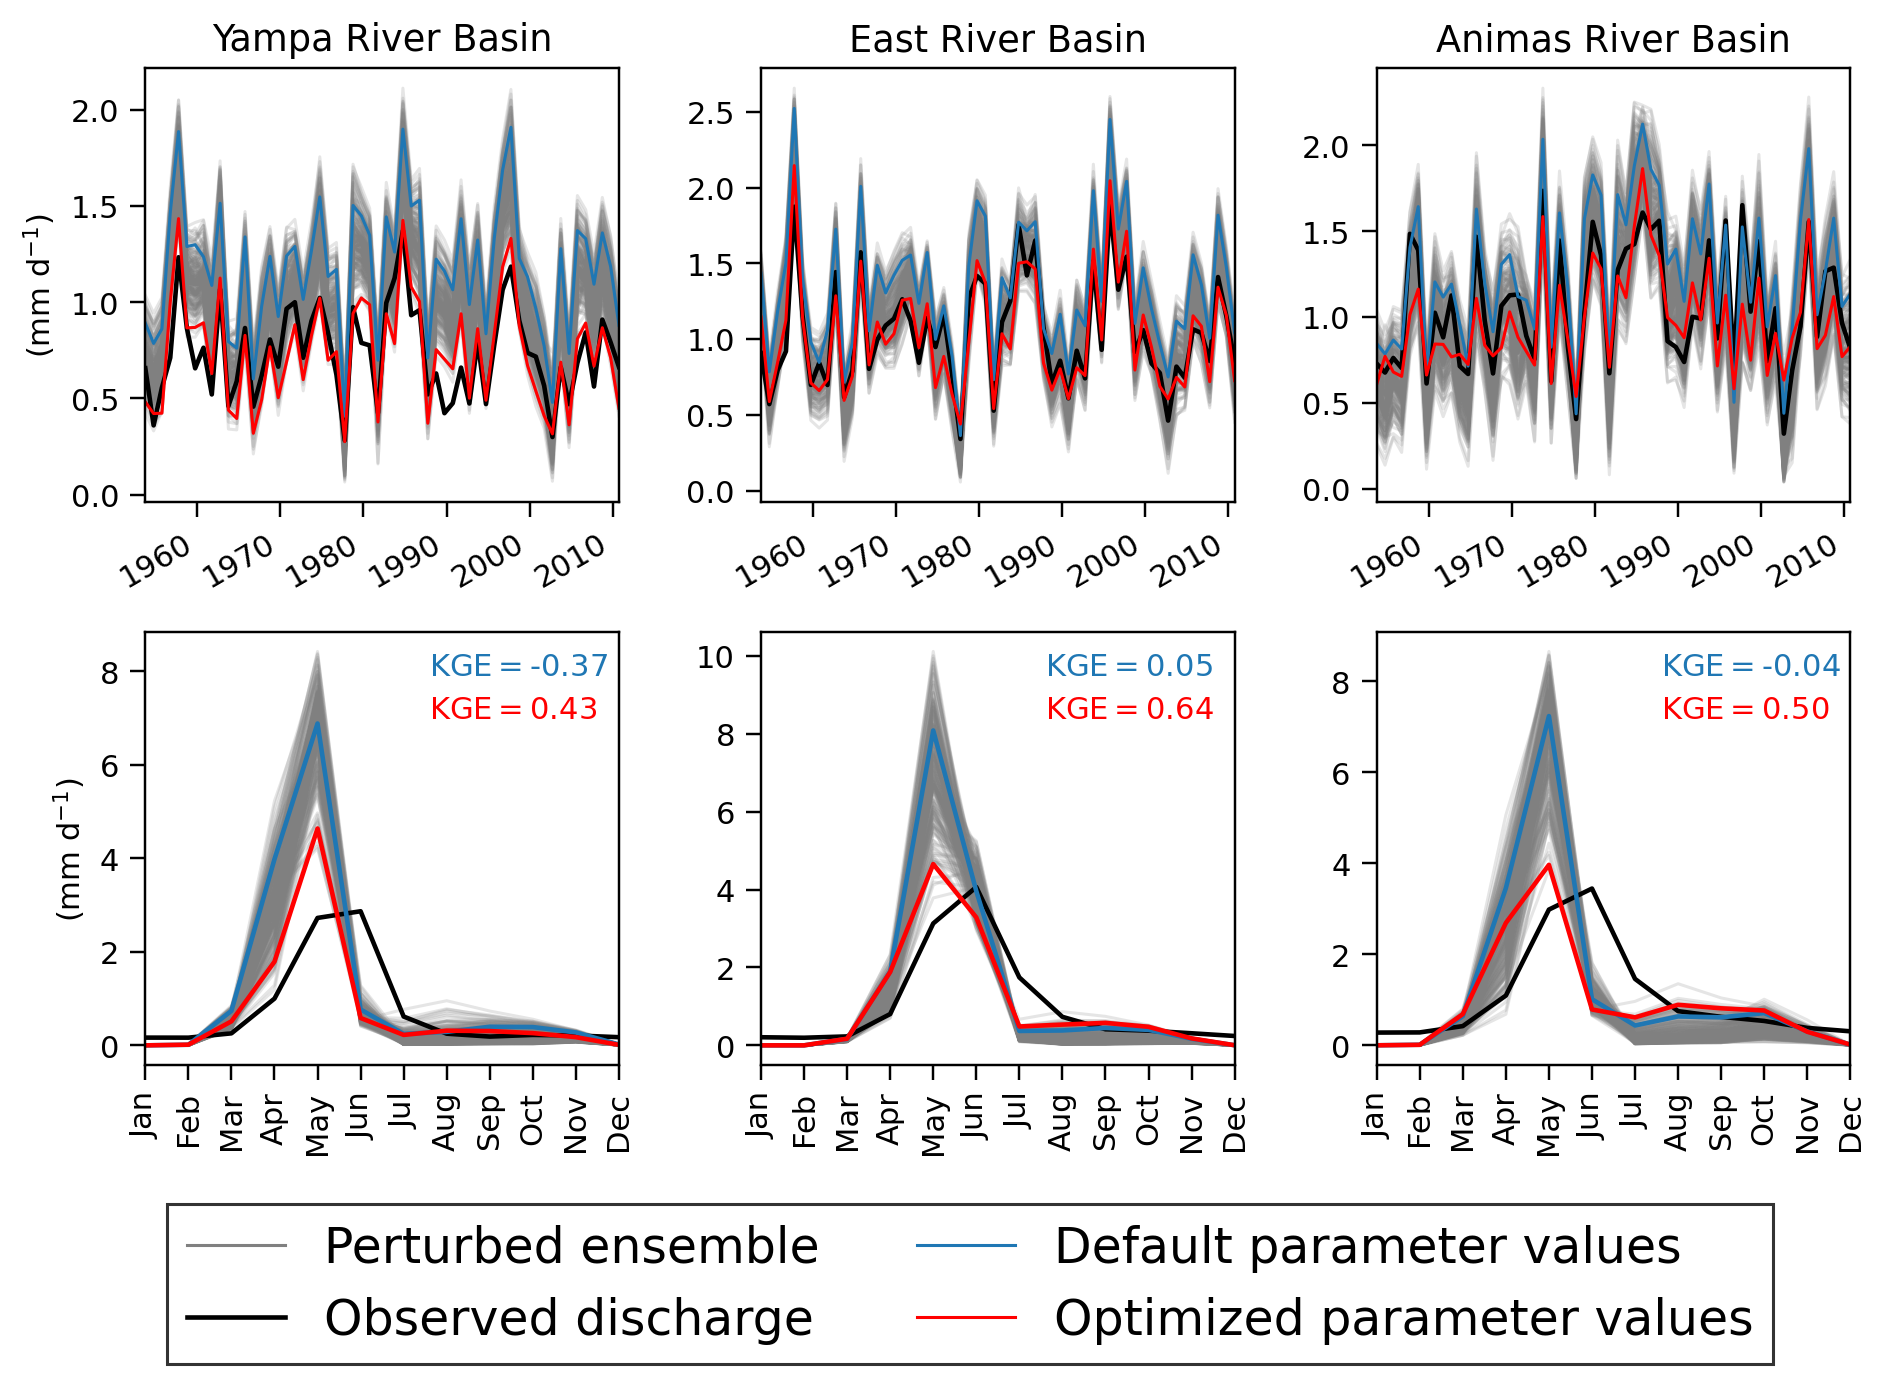

In [12]:
basins = ['yampa', 'east', 'animas', 'ucrb-0.9x1.25']
titles = ['Yampa River Basin', 'East River Basin', 'Animas River Basin', 'Upper Basin']
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
idxs = [15, 83, 83]
fig, axes_all = plt.subplots(2,3,figsize=(10,6), dpi=220, gridspec_kw={'hspace':0.3,'wspace':0.3})
for bii in range(3):
    ax = axes_all[1][bii]
    tag = basins[bii]
    A = areas[tag]
    ii = idxs[bii]
    
    ann_c = ds_lhs_optz_all[tag][:,:,0].groupby('time.month').mean()*24*60**2
    ann_c_obs = dict_qobs[tag].groupby('time.month').mean()/(A*10**6)*1000*24*60**2
    ann_c_optz = ds_lhs_optz_all[tag][ii,:,0].groupby('time.month').mean()*24*60**2
    ann_c_base = dict_rof_base[tag].groupby('time.month').mean()*24*60**2
    
    ann_c.plot.line(x='month', color='grey', add_legend=False, lw=1, ax=ax, alpha=.2)
    ann_c[0].plot(color='grey', lw=1, ax=ax, label='Perturbed ensemble runoff', alpha=.2)
    ann_c_obs.plot(c='k', ax=ax, lw=1.5, label='Observed discharge')
    ann_c_base.plot(c='tab:blue', ax=ax, lw=1.5)
    ann_c_optz.plot(c='red', ax=ax, lw=1.5, label='Optimized parameter values')
    
    ax.set_xticks(ann_c.month)
    ax.set_xticklabels(months, rotation=90)
    ax.tick_params(length=5)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.margins(x=0)
    kge_optz = dict_metrics_0[tag].iloc[ii]['kge']
    kge_base = dict_metrics_0[tag].iloc[-1]['kge']
    ax.annotate('KGE$=$%.2f'%kge_optz, (.6,.8), xycoords='axes fraction', color='red')
    ax.annotate('KGE$=$%.2f'%kge_base, (.6,.9), xycoords='axes fraction', color='tab:blue')
    
for bii in range(3):
    
    ax = axes_all[0][bii]
    tag = basins[bii]
    A = areas[tag]
    ii = idxs[bii]
    
    ann_c = ds_lhs_optz_all[tag][:,:,0].resample(time='A-SEP').mean()*24*60**2
    ann_c_obs = dict_qobs[tag].resample(time='A-SEP').mean()/(A*10**6)*1000*24*60**2
    ann_c_optz = ds_lhs_optz_all[tag][ii,:,0].resample(time='A-SEP').mean()*24*60**2
    ann_c_base = dict_rof_base[tag].resample(time='A-SEP').mean()*24*60**2

    ann_c['time'] = ann_c_obs.time
    ann_c_optz['time'] = ann_c_obs.time
    ann_c_base['time'] = ann_c_obs.time
    
    ann_c.plot.line(x='time', color='grey', add_legend=False, lw=1, ax=ax, alpha=.2)
    ann_c[0].plot(color='grey', lw=1, ax=ax, label='Perturbed ensemble', alpha=1)
    ann_c_obs.plot(c='k', ax=ax, lw=1.5, label='Observed discharge')
    ann_c_base.plot(c='tab:blue', ax=ax, lw=1, label='Default parameter values')
    ann_c_optz.plot(c='red', ax=ax, lw=1, label='Optimized parameter values')
    
    ax.tick_params(length=5)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.margins(x=0)
    ax.set_title(titles[bii])
    

axes_all[0,0].set_ylabel(r'(mm d$^{-1}$)')
axes_all[1,0].set_ylabel(r'(mm d$^{-1}$)')

h,l = ax.get_legend_handles_labels()
fig.legend(h,l, loc='lower center', fancybox=False, fontsize=16,
           bbox_to_anchor=(0.5,-0.12), ncol=2, edgecolor='k')

In [19]:
# ASMO iteration
init_iteration = 1
iteration=init_iteration + 1
wfile = '/glade/work/elkoukah/inputs/params/param_ens_ucrb_headwaters/optz_lhs_top6_all/pe_basin_%i_metrics_kge.pkl' % iter_
dict_metrics = pickle.load( open( wfile, "rb" ) )

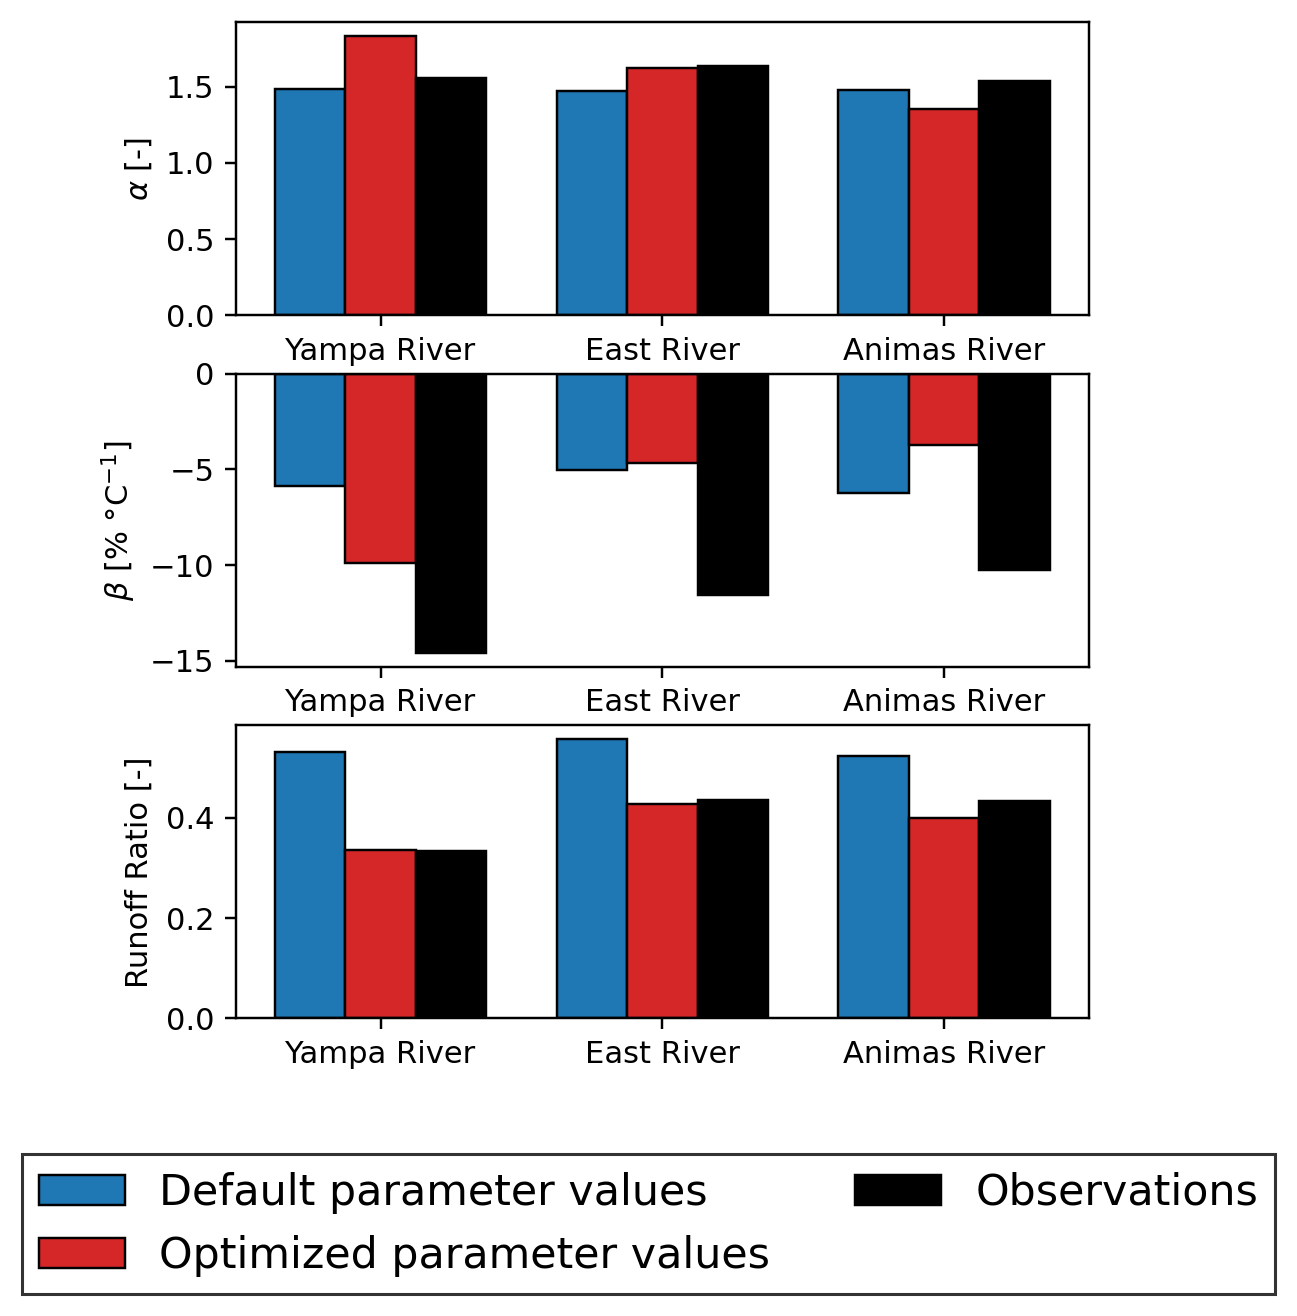

In [21]:
cols = ['alpha', 'beta', 'rratio']
ylabels = [r'$\alpha$ [-]', r'$\beta$ [% $\degree$C$^{-1}$]', 'Runoff Ratio [-]']
fig, axes = plt.subplots(3,1,figsize=(5,6), dpi=220, sharex=False,)
idxs = {'yampa':'pe_basin_0_0015','east':'pe_basin_0_0083','animas':'pe_basin_0_0083'}

for i in range(3):
    ax = axes[i]
    tag = 'yampa'
    col = cols[i]
    if i == 0:
        fc = 1
    elif i==1:
        fc = 100
    else:
        fc = 1
    w = .25
    x0 = w*2
    ax.bar(x0, dict_metrics[tag].loc['pe_basin_base', col]*fc, w, color='tab:blue', edgecolor='k', lw=.8, label='Default parameter values')
    ax.bar(x0+w, dict_metrics[tag].loc[idxs[tag], col]*fc, w, color='tab:red', edgecolor='k', lw=.8, label='Optimized parameter values')
    ax.bar(x0+w*2, dict_sens[tag][i]*fc, w, color='black', edgecolor='k', lw=.8, label='Observations')

    tag = 'east'
    x0 = x0+w*4
    ax.bar(x0, dict_metrics[tag].loc['pe_basin_base', col]*fc, w, color='tab:blue', edgecolor='k', lw=.8)
    ax.bar(x0+w, dict_metrics[tag].loc[idxs[tag], col]*fc, w, color='tab:red', edgecolor='k', lw=.8)
    ax.bar(x0+w*2, dict_sens[tag][i]*fc, w, color='black', edgecolor='k', lw=.8)

    tag = 'animas'
    x0 = x0+w*4
    ax.bar(x0, dict_metrics[tag].loc['pe_basin_base', col]*fc, w, color='tab:blue', edgecolor='k', lw=.8)
    ax.bar(x0+w, dict_metrics[tag].loc[idxs[tag], col]*fc, w, color='tab:red', edgecolor='k', lw=.8)
    ax.bar(x0+w*2, dict_sens[tag][i]*fc, w, color='black', edgecolor='k', lw=.8)
    
    ax.set_xticks([0.625+w/2, 1.625+w/2, 2.625+w/2, 3.625+w/2][:-1], labels=['Yampa River', 'East River', 'Animas River', 'Upper CRB'][:-1])
    ax.set_ylabel(ylabels[i])

h, l = axes[0].get_legend_handles_labels()
fig.legend(h, l, fancybox=False, edgecolor='k', fontsize=14,
           loc='lower center', ncol=2, bbox_to_anchor=(0.5,-.1))

## Optimization of sensitivities

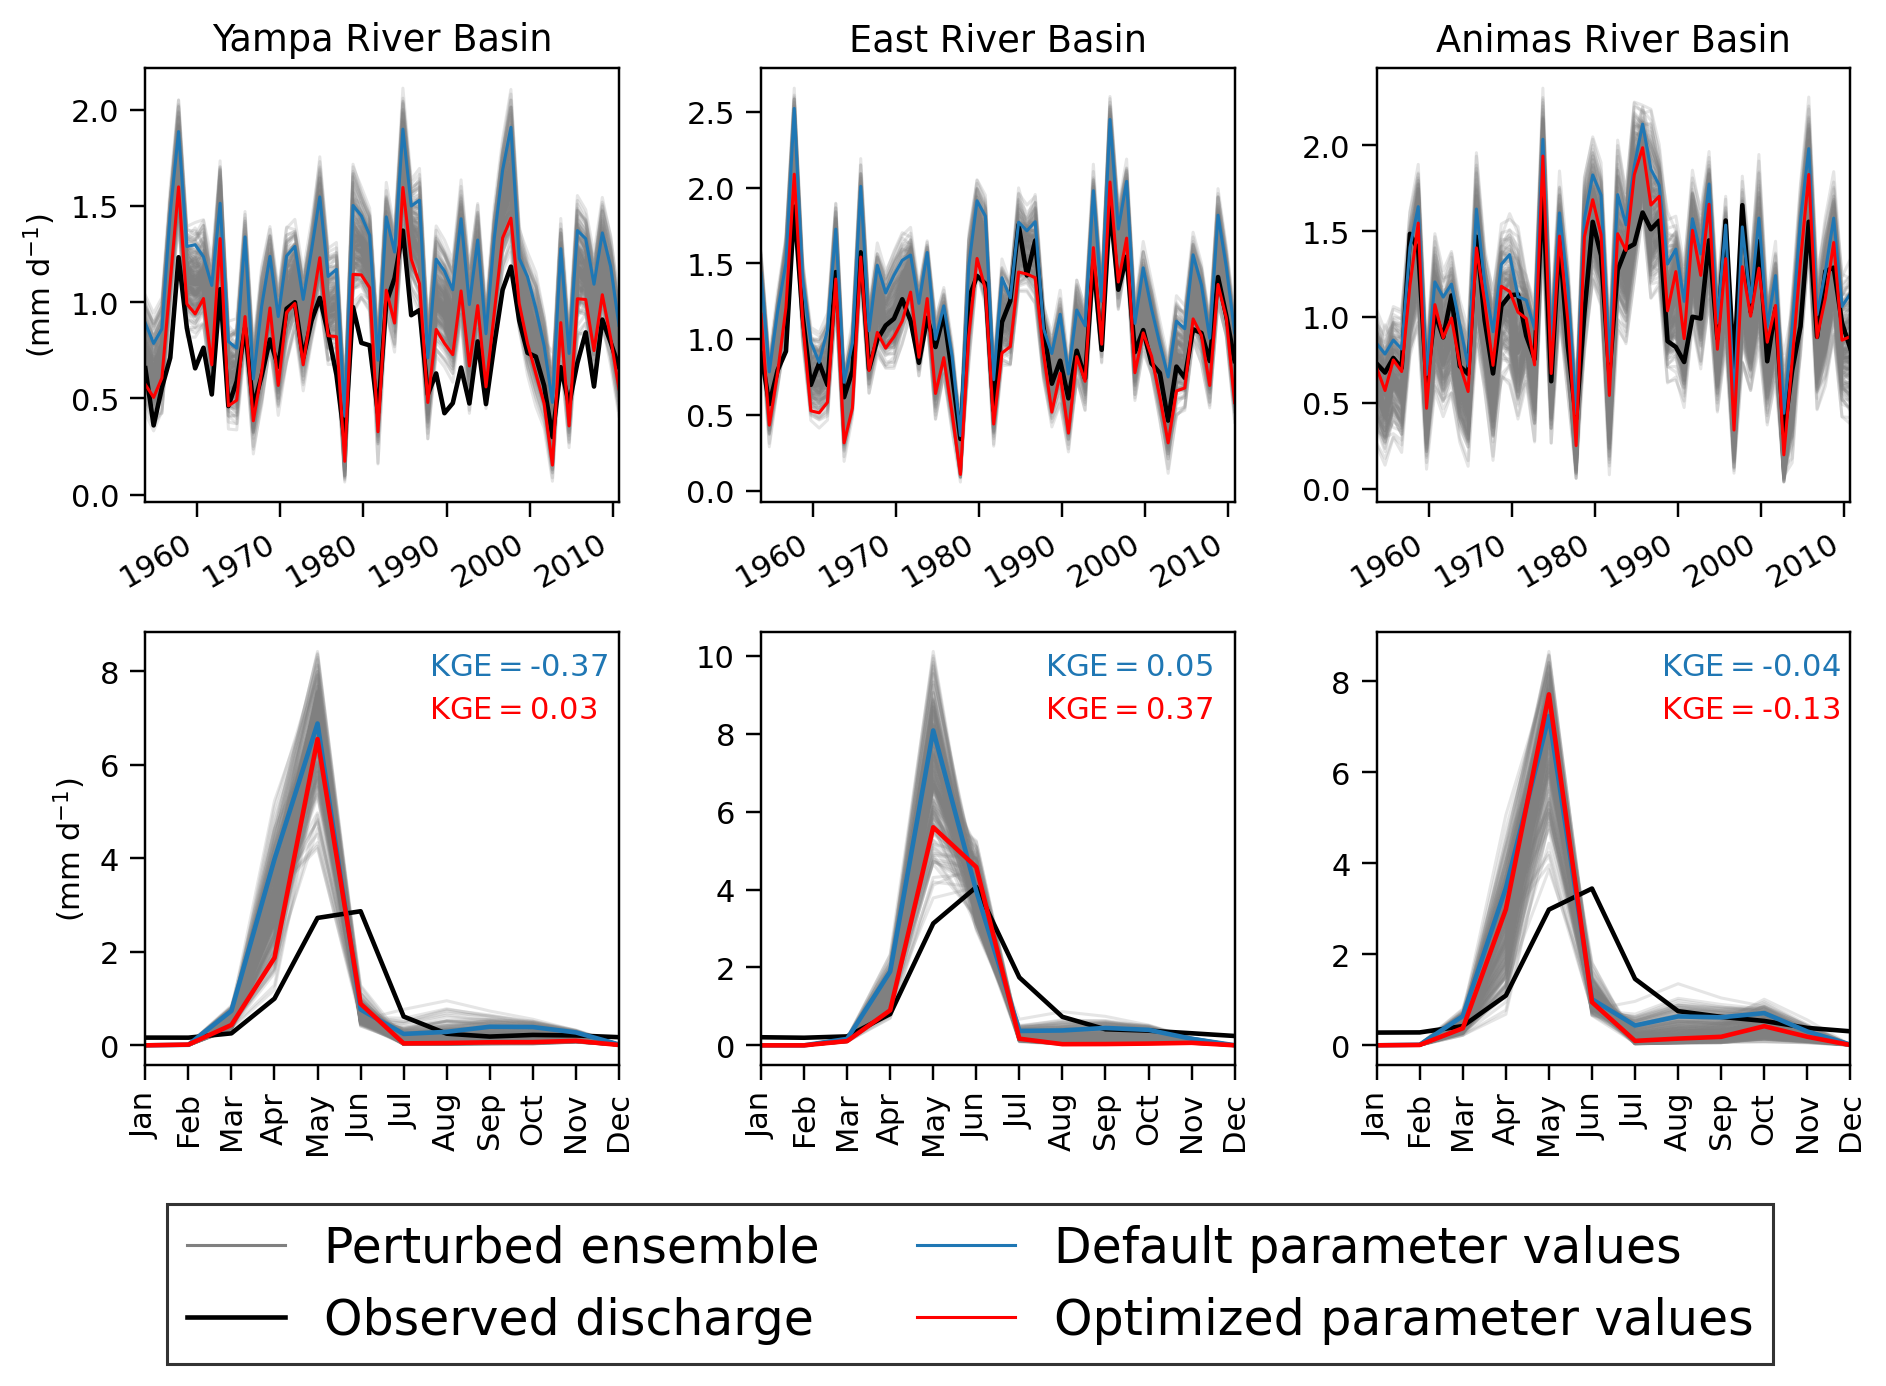

In [23]:
basins = ['yampa', 'east', 'animas', 'ucrb-0.9x1.25']
titles = ['Yampa River Basin', 'East River Basin', 'Animas River Basin', 'Upper Basin']
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
idxs = [164, 63, 113]
fig, axes_all = plt.subplots(2,3,figsize=(10,6), dpi=220, gridspec_kw={'hspace':0.3,'wspace':0.3})
for bii in range(3):
    ax = axes_all[1][bii]
    tag = basins[bii]
    A = areas[tag]
    ii = idxs[bii]
    
    ann_c = ds_lhs_optz_all[tag][:,:,0].groupby('time.month').mean()*24*60**2
    ann_c_obs = dict_qobs[tag].groupby('time.month').mean()/(A*10**6)*1000*24*60**2
    ann_c_optz = ds_lhs_optz_all[tag][ii,:,0].groupby('time.month').mean()*24*60**2
    ann_c_base = dict_rof_base[tag].groupby('time.month').mean()*24*60**2
    
    ann_c.plot.line(x='month', color='grey', add_legend=False, lw=1, ax=ax, alpha=.2)
    ann_c[0].plot(color='grey', lw=1, ax=ax, label='Perturbed ensemble runoff', alpha=.2)
    ann_c_obs.plot(c='k', ax=ax, lw=1.5, label='Observed discharge')
    ann_c_base.plot(c='tab:blue', ax=ax, lw=1.5)
    ann_c_optz.plot(c='red', ax=ax, lw=1.5, label='Optimized parameter values')
    
    ax.set_xticks(ann_c.month)
    ax.set_xticklabels(months, rotation=90)
    ax.tick_params(length=5)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.margins(x=0)
    kge_optz = dict_metrics_0[tag].iloc[ii]['kge']
    kge_base = dict_metrics_0[tag].iloc[-1]['kge']
    ax.annotate('KGE$=$%.2f'%kge_optz, (.6,.8), xycoords='axes fraction', color='red')
    ax.annotate('KGE$=$%.2f'%kge_base, (.6,.9), xycoords='axes fraction', color='tab:blue')
    
for bii in range(3):
    
    ax = axes_all[0][bii]
    tag = basins[bii]
    A = areas[tag]
    ii = idxs[bii]
    
    ann_c = ds_lhs_optz_all[tag][:,:,0].resample(time='A-SEP').mean()*24*60**2
    ann_c_obs = dict_qobs[tag].resample(time='A-SEP').mean()/(A*10**6)*1000*24*60**2
    ann_c_optz = ds_lhs_optz_all[tag][ii,:,0].resample(time='A-SEP').mean()*24*60**2
    ann_c_base = dict_rof_base[tag].resample(time='A-SEP').mean()*24*60**2

    ann_c['time'] = ann_c_obs.time
    ann_c_optz['time'] = ann_c_obs.time
    ann_c_base['time'] = ann_c_obs.time
    
    ann_c.plot.line(x='time', color='grey', add_legend=False, lw=1, ax=ax, alpha=.2)
    ann_c[0].plot(color='grey', lw=1, ax=ax, label='Perturbed ensemble', alpha=1)
    ann_c_obs.plot(c='k', ax=ax, lw=1.5, label='Observed discharge')
    ann_c_base.plot(c='tab:blue', ax=ax, lw=1, label='Default parameter values')
    ann_c_optz.plot(c='red', ax=ax, lw=1, label='Optimized parameter values')
    
    ax.tick_params(length=5)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.margins(x=0)
    ax.set_title(titles[bii])
    

axes_all[0,0].set_ylabel(r'(mm d$^{-1}$)')
axes_all[1,0].set_ylabel(r'(mm d$^{-1}$)')

h,l = ax.get_legend_handles_labels()
fig.legend(h,l, loc='lower center', fancybox=False, fontsize=16,
           bbox_to_anchor=(0.5,-0.12), ncol=2, edgecolor='k')

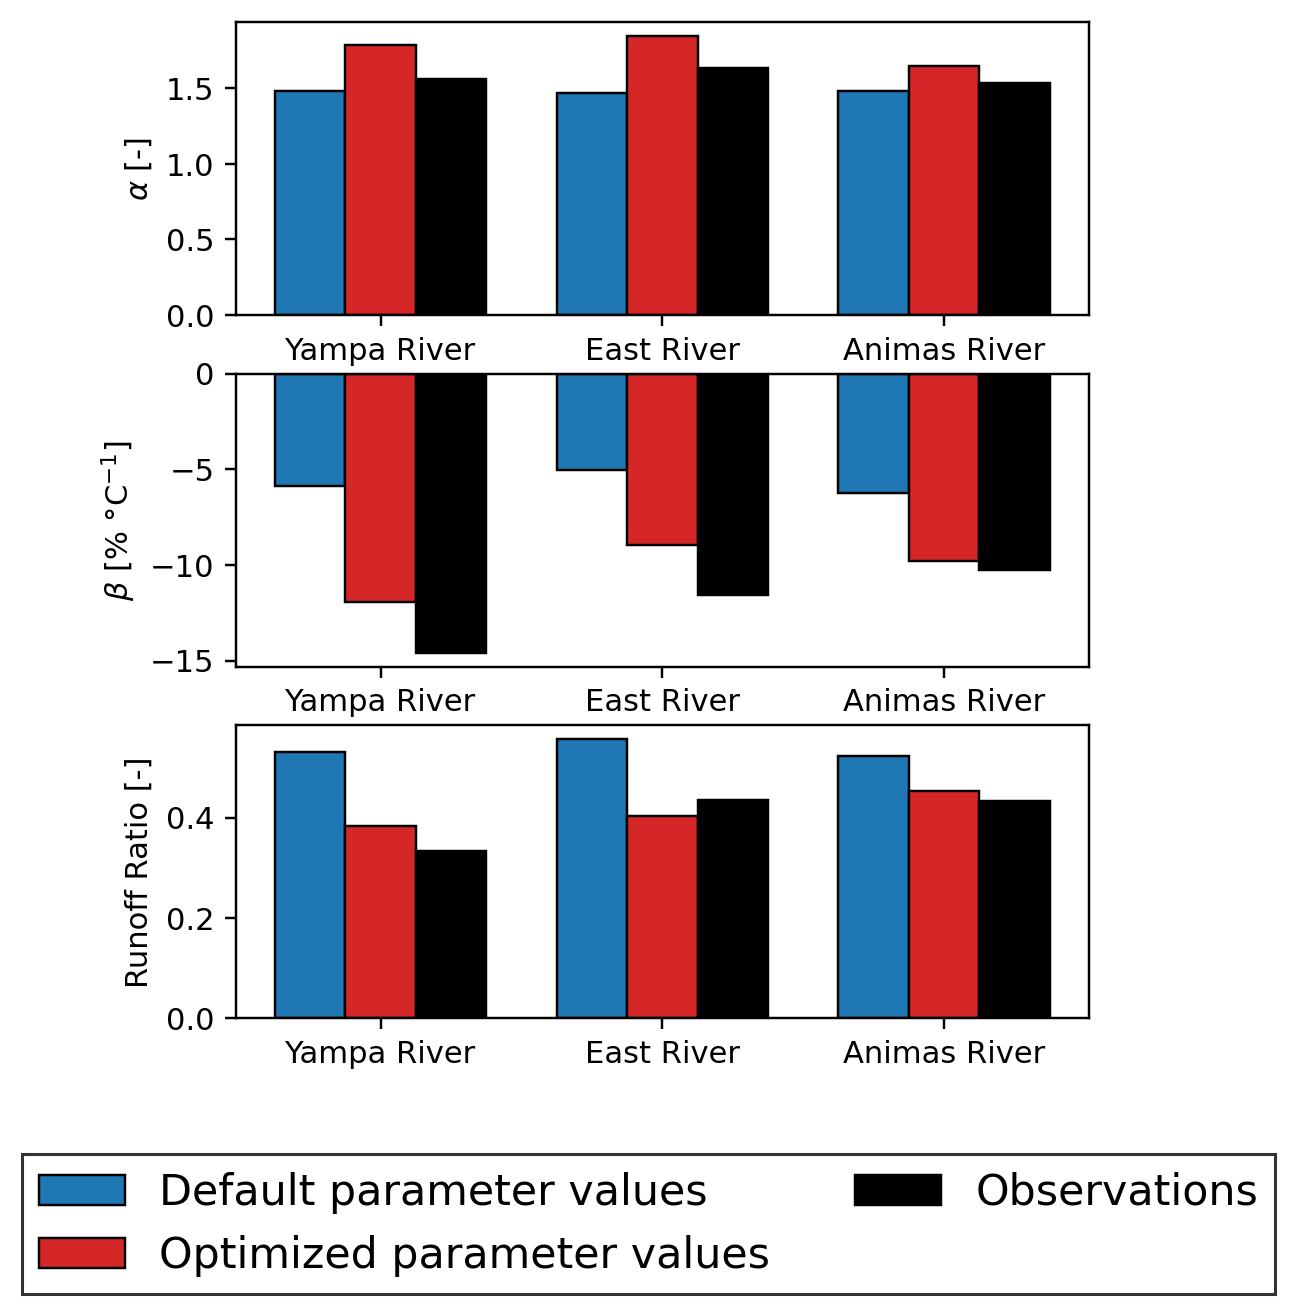

In [22]:
cols = ['alpha', 'beta', 'rratio']
ylabels = [r'$\alpha$ [-]', r'$\beta$ [% $\degree$C$^{-1}$]', 'Runoff Ratio [-]']
fig, axes = plt.subplots(3,1,figsize=(5,6), dpi=220, sharex=False,)
idxs = {'yampa':'pe_basin_0_0164','east':'pe_basin_0_0063','animas':'pe_basin_0_0113'}

for i in range(3):
    ax = axes[i]
    tag = 'yampa'
    col = cols[i]
    if i == 0:
        fc = 1
    elif i==1:
        fc = 100
    else:
        fc = 1
    w = .25
    x0 = w*2
    ax.bar(x0, dict_metrics[tag].loc['pe_basin_base', col]*fc, w, color='tab:blue', edgecolor='k', lw=.8, label='Default parameter values')
    ax.bar(x0+w, dict_metrics[tag].loc[idxs[tag], col]*fc, w, color='tab:red', edgecolor='k', lw=.8, label='Optimized parameter values')
    ax.bar(x0+w*2, dict_sens[tag][i]*fc, w, color='black', edgecolor='k', lw=.8, label='Observations')

    tag = 'east'
    x0 = x0+w*4
    ax.bar(x0, dict_metrics[tag].loc['pe_basin_base', col]*fc, w, color='tab:blue', edgecolor='k', lw=.8)
    ax.bar(x0+w, dict_metrics[tag].loc[idxs[tag], col]*fc, w, color='tab:red', edgecolor='k', lw=.8)
    ax.bar(x0+w*2, dict_sens[tag][i]*fc, w, color='black', edgecolor='k', lw=.8)

    tag = 'animas'
    x0 = x0+w*4
    ax.bar(x0, dict_metrics[tag].loc['pe_basin_base', col]*fc, w, color='tab:blue', edgecolor='k', lw=.8)
    ax.bar(x0+w, dict_metrics[tag].loc[idxs[tag], col]*fc, w, color='tab:red', edgecolor='k', lw=.8)
    ax.bar(x0+w*2, dict_sens[tag][i]*fc, w, color='black', edgecolor='k', lw=.8)
    
    ax.set_xticks([0.625+w/2, 1.625+w/2, 2.625+w/2, 3.625+w/2][:-1], labels=['Yampa River', 'East River', 'Animas River', 'Upper CRB'][:-1])
    ax.set_ylabel(ylabels[i])

h, l = axes[0].get_legend_handles_labels()
fig.legend(h, l, fancybox=False, edgecolor='k', fontsize=14,
           loc='lower center', ncol=2, bbox_to_anchor=(0.5,-.1))